# World Cup Simulation

After watching the world cup this year in Qatar and all the wild upsets there seemed to be, I got interested in the idea of trying to model the outcomes of games in order to predict winners. After doing some research on the internet, I found a great [medium article](https://medium.com/latinxinai/predicting-fifa-2022-world-cup-with-machine-learning-640f1d2d7e98) by Sergio Pessoa about this subject, so I thought it'd be fun to try my own hand at this task. I ended up using some of his code to read in and clean the data as well as run simulations, but used a different method for modelling game outcome probabilities.

The first step in the process was to read in all the world cup results and fifa rankings into a dataframe. You can see a printout of the resulting merged dataframe below.

In [1]:
import pandas as pd
from IPython.display import display

df =  pd.read_csv("./results.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)
df_wc = df

rank = pd.read_csv("./fifa_ranking-2022-10-06.csv")
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
rank_wc = rank

df_wc_ranked = df_wc.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

display(df_wc_ranked)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,2018-08-18,Andorra,United Arab Emirates,0,0,Friendly,Grödig,Austria,True,1120.00,1120.00,130.0,0.0,1312.00,1312.00,77.0,0.0
1,2018-08-18,Grenada,Jamaica,1,5,Friendly,St. George's,Grenada,False,980.00,980.00,168.0,0.0,1400.00,1400.00,54.0,0.0
2,2018-08-18,Guatemala,Cuba,1,0,Friendly,Quetzaltenango,Guatemala,False,1064.00,1064.00,146.0,0.0,940.00,940.00,181.0,0.0
3,2018-08-20,Barbados,Jamaica,2,2,Friendly,Bridgetown,Barbados,False,1005.00,1008.00,160.0,0.0,1400.00,1400.00,54.0,0.0
4,2018-08-26,Barbados,Cuba,0,0,Friendly,Bridgetown,Barbados,False,1005.00,1008.00,160.0,0.0,940.00,940.00,181.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,2022-09-27,Norway,Serbia,0,2,UEFA Nations League,Oslo,Norway,False,1488.57,1488.57,36.0,0.0,1549.53,1549.53,25.0,0.0
3335,2022-09-27,Sweden,Slovenia,1,1,UEFA Nations League,Stockholm,Sweden,False,1563.44,1563.44,20.0,0.0,1372.48,1372.48,65.0,0.0
3336,2022-09-27,Kosovo,Cyprus,5,1,UEFA Nations League,Pristina,Kosovo,False,1183.90,1183.90,106.0,0.0,1180.52,1180.52,108.0,1.0
3337,2022-09-27,Greece,Northern Ireland,3,1,UEFA Nations League,Athens,Greece,False,1441.45,1441.45,49.0,1.0,1399.10,1399.10,58.0,0.0


Next, I defined all the functions needed to simulate the outcome of a game between two countries and the associated probabilities of a loss, draw, or win. First, I calculate all the features needed for a specific team, then for each team I train a multinomial logistic regression model on a set of features since 2018. I used a multinomial logistic regression model to account for the three response variables of loss, draw, and win outcomes. The features used to train each model are fifa points, opponent points, team rank and opponent rank (not the most dynamic set of features I know...). Then, to account for two model outputs because each team has its own model, I take the outputs and simply average them. The result is a probability for loss, draw, and win which can then be used to sample an outcome based on those probabilities.

Because of the simplicity of the features used, this is perhaps not the most complex choice of model, but it would be pretty straightforward to add more features to these models like weather for example if the effort was made to scrape that data. Another downside to this approach is that only the first knockout round allows for matches to result in draws. The later stages go to penalty kicks if needed and no draw is possible. Penalty kicks are something that might be better off modeled separately because they are a slightly different skillset than regular soccer gameplay.

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression

def calc_team_features(df_wc_ranked, team):
    """ Calculate all features for a specific team
    """
    df_team = df_wc_ranked.copy(deep=True)
    df_team = df_team[(df_team["home_team"] == team) | (df_team["away_team"] == team)].sort_values(by="date", ascending=False)
    df_team[f"{team}_points"] = df_team.apply(lambda x: x.total_points_home if x.home_team==team else x.total_points_away,axis=1)
    df_team[f"opponent_points"] = df_team.apply(lambda x: x.total_points_home if x.home_team!=team else x.total_points_away,axis=1)
    df_team[f"{team}_goals"] = df_team.apply(lambda x: x.home_score if x.home_team==team else x.away_score,axis=1)
    df_team["opponent_goals"] = df_team.apply(lambda x: x.home_score if x.home_team!=team else x.away_score,axis=1)
    df_team[f"{team}_rank"] = df_team.apply(lambda x: x.rank_home if x.home_team==team else x.rank_away,axis=1)
    df_team["opponent_rank"] = df_team.apply(lambda x: x.rank_home if x.home_team!=team else x.rank_away,axis=1)
    df_team[f"{team}_win"] = df_team.apply(lambda x: 2 if x[f"{team}_goals"] > x.opponent_goals else 0, axis=1)
    df_team[f"{team}_win"] = df_team.apply(lambda x: 1 if x[f"{team}_goals"] == x.opponent_goals else x[f"{team}_win"], axis=1)

    return df_team

def fit_lr_from_team_df(team_df, team):
    """ Fit logistic regression model for team
    """
    X = team_df[[f"{team}_points", f"{team}_rank", "opponent_points", "opponent_rank"]]
    y = team_df[f"{team}_win"]
    clf = LogisticRegression(random_state=0, multi_class="multinomial", max_iter=1000).fit(X.values, y.values)
    return clf, X.columns

def predict_matchup_probs(team_a, team_b, df_wc_ranked):
    """ Predict matchup probabilities for pair of teams
    """
    team_a_df = calc_team_features(df_wc_ranked, team_a)
    team_b_df = calc_team_features(df_wc_ranked, team_b)
    model_a, columns_a = fit_lr_from_team_df(team_a_df, team_a)
    model_b, columns_b = fit_lr_from_team_df(team_b_df, team_b)

    team_a_features = team_a_df.sort_values(by="date").iloc[0][columns_a]
    team_b_features = team_b_df.sort_values(by="date").iloc[0][columns_b]

    team_a_features["opponent_rank"] = team_b_features[f"{team_b}_rank"]
    team_a_features["opponent_points"] = team_b_features[f"{team_b}_points"]

    team_b_features["opponent_rank"] = team_a_features[f"{team_a}_rank"]
    team_b_features["opponent_points"] = team_a_features[f"{team_a}_points"]

    team_a_predict = model_a.predict_proba(team_a_features.values.reshape(1,-1)).squeeze()
    team_b_predict = model_b.predict_proba(team_b_features.values.reshape(1,-1)).squeeze()

    # Team a lose, Team a draw, Team a win
    return np.mean([team_a_predict, team_b_predict[::-1]], axis=0)

def simulate_outcome(team_a, team_b, df_wc_ranked):
    """ Use probabilties to simulate an outcome
    """

    probs = predict_matchup_probs(team_a, team_b, df_wc_ranked)

    outcome_dict = {0: "Lose", 1: "Draw", 2: "Win"}
    outcome = np.random.choice([0,1,2], p=probs)

    return outcome_dict[outcome], probs



Here's an example simulated outcome where Germany beats Sweden where probabilities of loss, draw, and win for Germany are .108, .407, and .484 respectively. The way I set up the code, the probability outputs for a call to ```simulate_outcome``` will always result in the loss, draw, and win probabilities for the first team input into the function.

In [3]:
simulate_outcome("Germany", "Sweden", df_wc_ranked)

('Win', array([0.10834382, 0.40716244, 0.48449374]))

Next, I can read in some data from the world cup Wikipedia page on the schedule of games to get all the matchups (thank you to Sergio for this code - although I had to tweak it since the wikipedia page seems to have changed since Sergio published this).

In [4]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[9].iloc[:, 1].values)]

for i in range(12, 67, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        if group_count < len(groups) - 1:
            group_count+=1
            table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

Now, we can simulate the knockout round using the simulated outcomes!

In [5]:
from operator import itemgetter

advanced_group = []
last_group = ""
thresh = 0.05

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False

    outcome, probs = simulate_outcome(teams[1], teams[2], df_wc_ranked)
    
    if outcome == "Draw":
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif outcome == "Win":
        winner = teams[1]
        winner_proba = probs[2]
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif outcome == "Lose":  
        winner = teams[2]
        winner_proba = probs[0]
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[2].append(probs[2])
            if i[0] == teams[2]:
                i[2].append(probs[0])

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]:
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print(f"Group {teams[0]} - {teams[1]} vs. {teams[2]}: Winner {winner} with {probs} probs")
    else:
        print(f"Group {teams[0]} - {teams[1]} vs. {teams[2]}: Draw with {probs} probs")
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]:
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Senegal: Winner Senegal with [0.60440592 0.08547593 0.31011816] probs
Group A - Netherlands vs. Ecuador: Winner Netherlands with [0.25324966 0.13839087 0.60835947] probs
Group A - Ecuador vs. Senegal: Winner Senegal with [0.62165744 0.07157989 0.30676267] probs
Group A - Netherlands vs. Qatar: Winner Netherlands with [0.16330639 0.09224061 0.74445301] probs


Group A advanced: 
Netherlands -------- 6
Senegal -------- 6
Ecuador -------- 0
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Draw with [0.15437205 0.42272056 0.42290739] probs
Group B - United States vs. Wales: Winner Wales with [0.41453589 0.21946167 0.36600244] probs
Group B - Wales vs. Iran: Winner Wales with [0.24840713 0.45304828 0.29854459] probs
Group B - England vs. United States: Draw with [0.28958825 0.15192027 0.55849148] probs
Group B - Wales vs. England: Winner England with [0.63596508 0.1680

Now, we simulate the remaining rounds. In order to account for the fact that we can no longer have a draw, I add some logic to rerun the simulation until we don't get a draw as an outcome. This is a bit flawed because like I mentioned earlier the penalty kick scenario would probably warrant a different model than the regular gameplay models!

In [6]:
advanced = advanced_group
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = home
            team_2 = away

            outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
            while outcome == "Draw":
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

            team_1_prob = probs[0]
            team_2_prob = probs[2]

            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if outcome == "Lose":
                print(f"{home} vs. {away}: {away} advances with probs {probs}")
                next_rounds.append(away)
            else:
                print(f"{home} vs. {away}: {home} advances with probs {probs}")
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = home
            team_2 = away
            outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
            while outcome == "Draw":
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

            team_1_prob = probs[0]
            team_2_prob = probs[2]
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")

            if outcome == "Lose":
                print(f"{home} vs. {away}: {away} advances with probs {probs}")
                next_rounds.append(away)
            else:
                print(f"{home} vs. {away}: {home} advances with probs {probs}")
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. England: England advances with probs [0.52997262 0.14980499 0.32022239]
Argentina vs. Denmark: Argentina advances with probs [0.29706669 0.30152719 0.40140612]
Germany vs. Croatia: Germany advances with probs [0.21623629 0.40266932 0.38109439]
Brazil vs. Uruguay: Brazil advances with probs [0.2979174  0.28979272 0.41228988]
Senegal vs. Wales: Senegal advances with probs [0.28773085 0.14210434 0.57016481]
Mexico vs. France: Mexico advances with probs [0.64693675 0.18927285 0.1637904 ]
Japan vs. Belgium: Belgium advances with probs [0.80588072 0.02225779 0.17186149]
Serbia vs. Portugal: Portugal advances with probs [0.48509392 0.38840248 0.1265036 ]
----------
Starting simulation of Quarter-Final
----------


England vs. Argentina: England advances with probs [0.28325966 0.24448768 0.47225266]
Germany vs. Brazil: Brazil advances with probs [0.37623747 0.44763366 0.17612888]
Senegal vs. Mexico: Mexico advances with

Finally we can run 500 simulations and track the outputs of all of them to see which country wins most often.

In [7]:
# Total sim
from operator import itemgetter
from tqdm import tqdm
verbose = False
wc_winners = []

for sim in tqdm(range(500)):
    advanced_group = []
    last_group = ""
    thresh = 0.05

    for k in table.keys():
        for t in table[k]:
            t[1] = 0
            t[2] = []
        
    for teams in matches:
        draw = False

        outcome, probs = simulate_outcome(teams[1], teams[2], df_wc_ranked)
        
        if outcome == "Draw":
            draw=True
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1
                    
        elif outcome == "Win":
            winner = teams[1]
            winner_proba = probs[2]
            for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[1] += 3
                    
        elif outcome == "Lose":  
            winner = teams[2]
            winner_proba = probs[0]
            for i in table[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3
        
        for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[2].append(probs[2])
                if i[0] == teams[2]:
                    i[2].append(probs[0])

        if last_group != teams[0]:
            if last_group != "":
                if verbose == True:
                    print("\n")
                    print("Group %s advanced: "%(last_group))
                
                for i in table[last_group]:
                    i[2] = np.mean(i[2])
                
                final_points = table[last_group]
                final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
                advanced_group.append([final_table[0][0], final_table[1][0]])
                for i in final_table:
                    if verbose == True:
                        print("%s -------- %d"%(i[0], i[1]))
            if verbose == True:
                print("\n")
                print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
            
        if verbose == True:
            if draw == False:
                print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
            else:
                print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
        last_group =  teams[0]

    if verbose == True:
        print("\n")
        print("Group %s advanced: "%(last_group))

    for i in table[last_group]:
        i[2] = np.mean(i[2])
                
    final_points = table[last_group]
    final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
    advanced_group.append([final_table[0][0], final_table[1][0]])
    for i in final_table:
        if verbose == True:
            print("%s -------- %d"%(i[0], i[1]))

    advanced = advanced_group
    playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

    for p in playoffs.keys():
        playoffs[p] = []

    actual_round = ""
    next_rounds = []

    for p in playoffs.keys():
        if p == "Round of 16":
            control = []
            for a in range(0, len(advanced*2), 1):
                if a < len(advanced):
                    if a % 2 == 0:
                        control.append((advanced*2)[a][0])
                    else:
                        control.append((advanced*2)[a][1])
                else:
                    if a % 2 == 0:
                        control.append((advanced*2)[a][1])
                    else:
                        control.append((advanced*2)[a][0])

            playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
            
            for i in range(0, len(playoffs[p]), 1):
                game = playoffs[p][i]
                
                home = game[0]
                away = game[1]
                team_1 = home
                team_2 = away

                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
                while outcome == "Draw":
                    outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

                team_1_prob = probs[0]
                team_2_prob = probs[2]

                if actual_round != p:
                    if verbose == True:
                        print("-"*10)
                        print("Starting simulation of %s"%(p))
                        print("-"*10)
                        print("\n")
                
                if outcome == "Lose":
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p
            
        else:
            playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
            next_rounds = []
            for i in range(0, len(playoffs[p])):
                game = playoffs[p][i]
                home = game[0]
                away = game[1]
                team_1 = home
                team_2 = away
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
                while outcome == "Draw":
                    outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

                team_1_prob = probs[0]
                team_2_prob = probs[2]
                
                if actual_round != p:
                    if verbose == True:
                        print("-"*10)
                        print("Starting simulation of %s"%(p))
                        print("-"*10)
                        print("\n")

                if outcome == "Lose":
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p

                if (p=="Final"):
                    wc_winners.append(next_rounds[0])

100%|██████████| 500/500 [18:59<00:00,  2.28s/it]  


If we now print out a histogram of all the winners we can see which teams win most often. Clearly France is quite the heavy favorite!

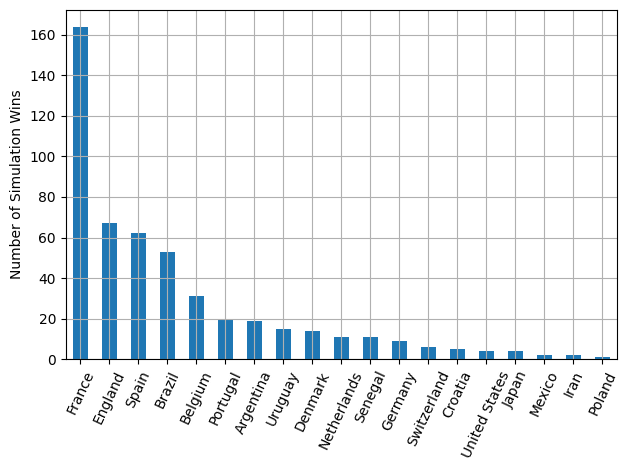

In [8]:
from matplotlib import pyplot as plt
wc_winner_df = pd.DataFrame(wc_winners, columns=["wc_winners"])
wc_winner_df["wc_winners"].value_counts().plot.bar()
plt.grid()
plt.ylabel("Number of Simulation Wins")
plt.xticks(rotation=65)
plt.tight_layout()

Lastly, we can divide by the total number of simulations to compute a probability for each team to win. France is the overwhelming favorite, and amazingly Argentina has only about a 3.8% chance to win according to this analysis! This is a pretty simplistic model and analysis but it's pretty interesting to see the results and how favored France is using these assumptions!

In [9]:
wc_winner_df.value_counts()/500

wc_winners   
France           0.328
England          0.134
Spain            0.124
Brazil           0.106
Belgium          0.062
Portugal         0.040
Argentina        0.038
Uruguay          0.030
Denmark          0.028
Netherlands      0.022
Senegal          0.022
Germany          0.018
Switzerland      0.012
Croatia          0.010
United States    0.008
Japan            0.008
Iran             0.004
Mexico           0.004
Poland           0.002
dtype: float64